# Intro
Raw code for experimentation

In [1]:
from fastbook import *
from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

## Classifier

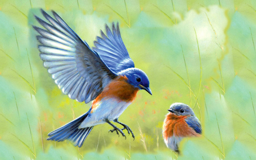

In [2]:
download_url(search_images_ddg('bird photos', max_images=1)[0], 'bird.jpg')
Image.open('bird.jpg').to_thumb(256, 256)

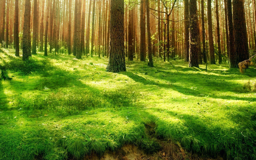

In [3]:
download_url(search_images_ddg('forest photos', max_images=1)[0], 'forest.jpg')
Image.open('forest.jpg').to_thumb(256, 256)

In [4]:
searches = 'forest','bird'
path = Path('bird_or_not')

In [5]:
if not path.exists():
    for o in searches:
        dest = (path/o)
        dest.mkdir(parents=True,exist_ok=True)
        results = search_images_ddg(f'{o} photo')
        download_images(dest, urls=results[:200])
        resize_images(dest, max_size=400, dest=dest)

In [6]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)

(#0) []

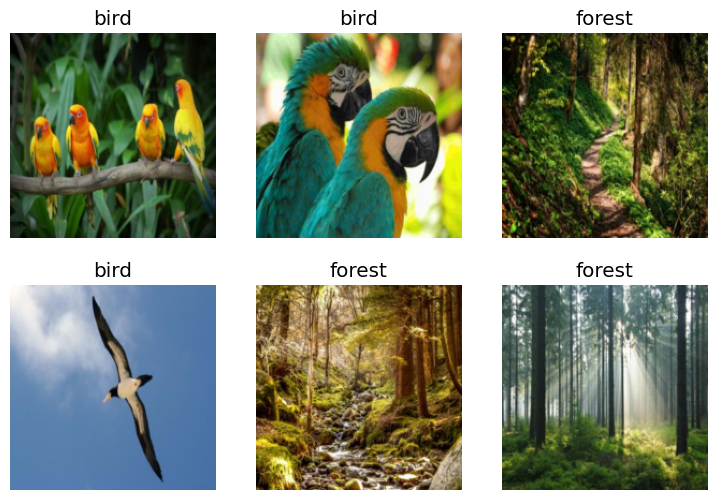

In [7]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

In [8]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.055454,0.035612,0.013158,00:00
1,0.031750,0.001773,0.000000,00:00
2,0.020932,0.001520,0.000000,00:00


In [9]:
is_bird,_,probs = learn.predict(PILImage.create('bird_or_not/forest/forest.jpg'))
print(f"This is a: {is_bird}")
print(f"probability it's a bird: {probs[0]:.4f}")
print(f"probability it's a forest: {probs[1]:.4f}")

This is a: forest
probability it's a bird: 0.0000
probability it's a forest: 1.0000


## Segmentation

In [10]:
import torch
torch.cuda.empty_cache()
path = untar_data(URLs.CAMVID_TINY)
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = get_image_files(path/"images"),
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = np.loadtxt(path/'codes.txt', dtype=str)
)

learn = unet_learner(dls, resnet34)
learn.fine_tune(120)

KeyboardInterrupt: 

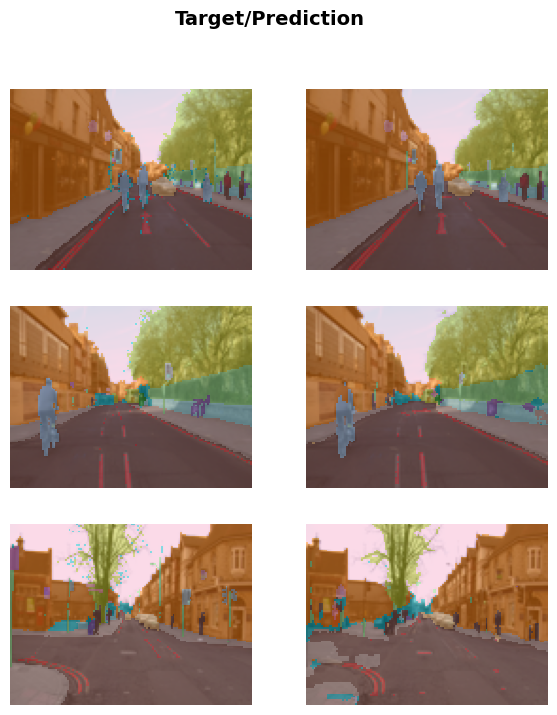

In [ ]:
learn.show_results(max_n=3, figsize=(7,8))

## Tabular Analysis

In [12]:
from fastai.tabular.all import *
path = untar_data(URLs.ADULT_SAMPLE)

dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names='salary',
                                  cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship'],
                                  cont_names = ['age', 'fnlwgt', 'education-num'],
                                  procs = [Categorify, FillMissing, Normalize]
                                  )

In [13]:
dls.show_batch()

,workclass,education,marital-status,occupation,relationship,education-num_na,age,fnlwgt,education-num,salary
0,State-gov,Bachelors,Married-civ-spouse,Protective-serv,Husband,False,25.0,262664.001254,13.0,>=50k
1,Private,Some-college,Married-civ-spouse,Craft-repair,Husband,False,43.0,55394.998497,10.0,<50k
2,Self-emp-not-inc,HS-grad,Married-civ-spouse,Farming-fishing,Husband,False,51.0,156801.999536,9.0,>=50k
3,Federal-gov,HS-grad,Married-civ-spouse,Adm-clerical,Husband,False,45.0,181969.999731,9.0,<50k
4,Private,Assoc-voc,Divorced,Adm-clerical,Unmarried,False,38.0,411797.005132,11.0,<50k
5,Private,Some-college,Never-married,Other-service,Unmarried,False,39.0,158955.999220,10.0,<50k
6,Local-gov,HS-grad,Married-civ-spouse,Handlers-cleaners,Husband,False,50.0,231724.999023,9.0,<50k
7,Private,Masters,Divorced,Exec-managerial,Unmarried,False,43.0,115806.000281,14.0,>=50k
8,Private,11th,Divorced,Craft-repair,Not-in-family,False,56.0,271794.998970,7.0,<50k
9,Private,HS-grad,Divorced,Tech-support,Not-in-family,False,46.0,295791.002851,9.0,<50k


In [19]:
learn = tabular_learner(dls, metrics=accuracy)
learn.fit_one_cycle(2)
learn.show_results()

AssertionError: `n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`

## Recommendations

In [15]:
from fastai.collab import *
path = untar_data(URLs.ML_SAMPLE)
dls = CollabDataLoaders.from_csv(path/'ratings.csv')

In [16]:
dls.show_batch()

,userId,movieId,rating
0,130,293,4.0
1,505,480,3.0
2,402,5952,4.0
3,239,1073,3.0
4,380,344,4.0
5,306,733,4.0
6,468,364,3.5
7,665,4306,5.0
8,17,541,5.0
9,615,6377,4.5


In [17]:
learn = collab_learner(dls, y_range=(0.5, 5.5))
learn.fine_tune(10)

epoch,train_loss,valid_loss,time
0,1.374860,1.350394,00:00
1,1.287999,1.169781,00:00
2,1.031497,0.867560,00:00
3,0.796313,0.731387,00:00
4,0.688329,0.698444,00:00
5,0.642904,0.692010,00:00
6,0.622824,0.689128,00:00
7,0.612655,0.687250,00:00
8,0.605519,0.686323,00:00
9,0.595020,0.686292,00:00


In [26]:
learn.show_results()

,userId,movieId,rating,rating_pred
0,30.0,74.0,5.0,3.763442
1,30.0,75.0,4.0,4.305429
2,28.0,9.0,1.5,3.140058
3,98.0,17.0,4.0,3.774874
4,18.0,94.0,4.0,3.496572
5,1.0,57.0,4.0,3.656664
6,53.0,18.0,5.0,4.607825
7,79.0,45.0,5.0,4.669981
8,91.0,71.0,4.0,3.118788
